In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [3]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


In [4]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 30828
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


In [5]:
filenames = filenames[:28000]

train_files = filenames[:19600]
val_files = filenames[19600: 19600 + 5600]
test_files = filenames[-2800:]

print('Размер обучающего набора', len(train_files))
print('Размер проверочного набора', len(val_files))
print('Размер тестового набора', len(test_files))

Размер обучающего набора 19600
Размер проверочного набора 5600
Размер тестового набора 2800


In [6]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11506, 1])

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def without_zero_len(waveform, label):
    if len(waveform)!=0:  
        return True
    return False

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
count = 0
for a,_ in waveform_ds:
    count+=1
    if a.shape[0]==0:
        print(count, filenames[count])
waveform_ds = waveform_ds.filter(without_zero_len) # Удаляем сигналы нулевой длины

1171 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en045a_5.wav', shape=(), dtype=string)
2199 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en022b_76.wav', shape=(), dtype=string)
4355 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en049a_84.wav', shape=(), dtype=string)
4425 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\E\\kr021b_42.wav', shape=(), dtype=string)
8201 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\kr002b_204.wav', shape=(), dtype=string)
9690 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\kr038b_134.wav', shape=(), dtype=string)
12707 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D\\kr019a_8.wav', shape=(), dtype=string)
14965 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en012b_80.wav', shape=(), dtype=string)
17485 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\C#\\kr005b_65.wav', shape=(), dtype=string)
19349 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en031a_54.wav', shape=(), dtype=string)


In [9]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(1025, 40)


In [10]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    NFFT = 2048
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров

    return spectrogram

In [11]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [12]:
step = list(map(int,[2048/32, 2048/16, 2048/8, 2048/4, 2048/2, 2048]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


In [13]:
params_s_f

[(64, 5),
 (64, 10),
 (64, 15),
 (64, 20),
 (64, 25),
 (64, 30),
 (128, 5),
 (128, 10),
 (128, 15),
 (128, 20),
 (128, 25),
 (128, 30),
 (256, 5),
 (256, 10),
 (256, 15),
 (256, 20),
 (256, 25),
 (256, 30),
 (512, 5),
 (512, 10),
 (512, 15),
 (512, 20),
 (512, 25),
 (512, 30),
 (1024, 5),
 (1024, 10),
 (1024, 15),
 (1024, 20),
 (1024, 25),
 (1024, 30),
 (2048, 5),
 (2048, 10),
 (2048, 15),
 (2048, 20),
 (2048, 25),
 (2048, 30)]

In [14]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.filter(without_zero_len) 
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [15]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [16]:
import time
EPOCHS = 100
models = []
histories = []

__________________________________

In [17]:
tests_acc = []
EPOCHS = [10,50,75,100,300,500]
models = []
histories = []

train_ds = []
val_ds = []
test_ds = []
spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,512), num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,30))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,512,30)
test_ds = preprocess_dataset(test_files,512,30)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)



input_shape (30, 40)


In [18]:
for k in range(len(EPOCHS)):
    print('---------------------------------------------------------------------')

    mymodel = create_model(input_shape)

    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS[k], verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")

    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Эпохи: ',EPOCHS[k], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

---------------------------------------------------------------------
--- 0.0 минут 53.31460499763489 секунд ---
Эпохи:  10 , accuracy тестовой выборки:  88.23739721129782 %
---------------------------------------------------------------------
--- 1.0 минут 38.82662343978882 секунд ---
Эпохи:  50 , accuracy тестовой выборки:  91.81265641759028 %
---------------------------------------------------------------------
--- 2.0 минут 35.36499214172363 секунд ---
Эпохи:  75 , accuracy тестовой выборки:  92.17018233821952 %
---------------------------------------------------------------------
--- 3.0 минут 26.160568952560425 секунд ---
Эпохи:  100 , accuracy тестовой выборки:  92.20593493028244 %
---------------------------------------------------------------------
--- 10.0 минут 0.407623291015625 секунд ---
Эпохи:  300 , accuracy тестовой выборки:  92.92098677154094 %
---------------------------------------------------------------------
--- 16.0 минут 41.49622440338135 секунд ---
Эпохи:  500 

In [19]:
k_max = np.argmax(np.array(tests_acc))
k_max

5

In [20]:
history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

93.31426528423312

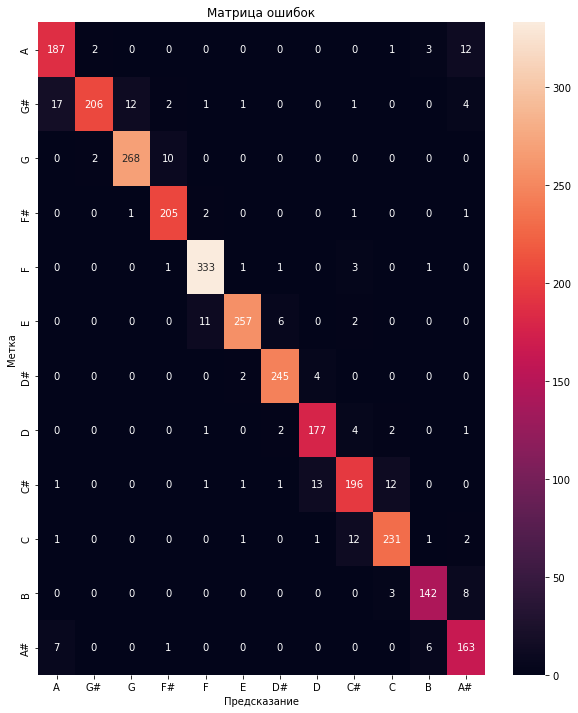

In [21]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [22]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)
files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
output_ds = output_ds.filter(without_zero_len) 
output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,512), num_parallel_calls=AUTOTUNE)
sample_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,30))

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


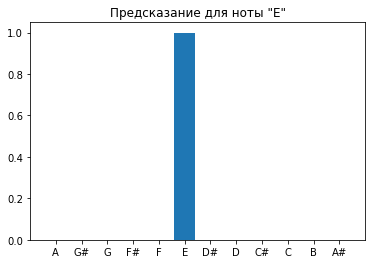

In [23]:
for spectrogram, label in sample_ds.batch(1):
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

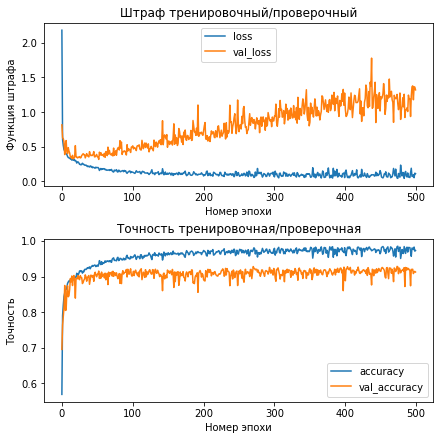

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [25]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_3.h5")

In [26]:
model_.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 30, 40)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 1200)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               614912    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 1,146,380
Trainable params: 1,146,380
Non-tra

_______________________________________________

In [98]:
start_time0 = time.time()
tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    train_ds = []
    val_ds = []
    test_ds = []
    spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k][0]), num_parallel_calls=AUTOTUNE)
    spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k][1]))
    train_ds = spectrogram_ds
    val_ds = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ds = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    
    batch_size = 64
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    for spectrogram, _ in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
        print('input_shape',input_shape)
    
    
    mymodel = create_model(input_shape)
    
    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)
    
    
minutes, seconds = ((time.time() - start_time0) - 3600 * ((time.time() - start_time0) // 3600)) // 60, (time.time() - start_time0) % 60    
print(f"--- {minutes} минут {seconds} секунд ---")

---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  5
input_shape (5, 40)
--- 5.0 минут 53.64996552467346 секунд ---
Шаг: 64 , количество спектрограмм:  5 , accuracy тестовой выборки:  71.21916338934572 %
---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  10
input_shape (10, 40)
--- 6.0 минут 18.364998817443848 секунд ---
Шаг: 64 , количество спектрограмм:  10 , accuracy тестовой выборки:  74.0793707543797 %
---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  15
input_shape (15, 40)
--- 7.0 минут 53.74026608467102 секунд ---
Шаг: 64 , количество спектрограмм:  15 , accuracy тестовой выборки:  73.32856632105828 %
---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  20
input_shape (20, 40)
--- 8.0 минут 37.984944581985474 секунд ---
Шаг: 64 , количество спектрограмм:  20 , ac

input_shape (10, 40)
--- 8.0 минут 24.262557983398438 секунд ---
Шаг: 2048 , количество спектрограмм:  10 , accuracy тестовой выборки:  92.17018233821952 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  15
input_shape (15, 40)
--- 8.0 минут 18.71750497817993 секунд ---
Шаг: 2048 , количество спектрограмм:  15 , accuracy тестовой выборки:  90.77583124776545 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  20
input_shape (20, 40)
--- 9.0 минут 10.680687665939331 секунд ---
Шаг: 2048 , количество спектрограмм:  20 , accuracy тестовой выборки:  89.27422238112264 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  25
input_shape (25, 40)
--- 8.0 минут 37.91634750366211 секунд ---
Шаг: 2048 , количество спектрограмм:  25 , accuracy тестовой выборки:  90.38255273507329 %
---------------------------------------------

In [ ]:
for k in range(len(models)):
    print(k, params_s_f[k][0])
    models[k].summary()

In [99]:
np.array(tests_acc)

array([71.21916339, 74.07937075, 73.32856632, 74.68716482, 76.97533071,
       77.79764033, 71.25491598, 74.29388631, 75.6882374 , 80.58634251,
       80.193064  , 84.80514837, 71.68394709, 79.19199142, 82.15945656,
       86.37826242, 88.7379335 , 88.38040758, 79.7282803 , 82.73149803,
       89.66750089, 90.06077941, 90.77583125, 92.84948159, 85.5917054 ,
       89.48873793, 88.66642832, 86.59277798, 91.13335717, 89.34572757,
       91.31212013, 92.17018234, 90.77583125, 89.27422238, 90.38255274,
       86.9145513 ])

Text(51.0, 0.5, 'Шаг')

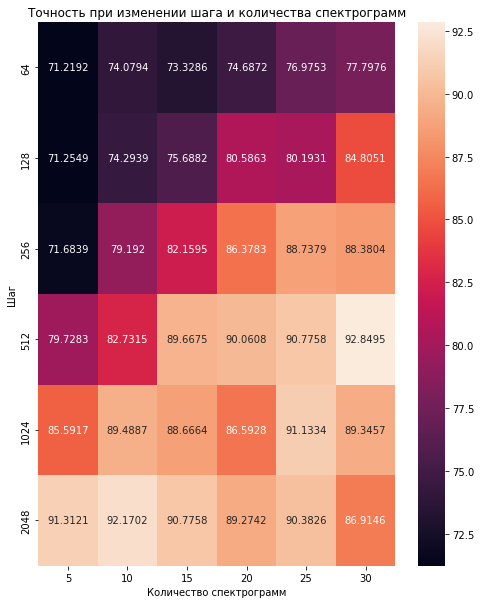

In [100]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

Лучшая точность $(92.8495 \%)$ соответствует $30$ спектрограммам и шагу $512$.

In [101]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (64, 5) 71.21916338934572
1 (64, 10) 74.0793707543797
2 (64, 15) 73.32856632105828
3 (64, 20) 74.6871648194494
4 (64, 25) 76.97533071147659
5 (64, 30) 77.79764032892385
6 (128, 5) 71.25491598140866
7 (128, 10) 74.29388630675724
8 (128, 15) 75.6882373972113
9 (128, 20) 80.58634250983197
10 (128, 25) 80.19306399713979
11 (128, 30) 84.80514837325707
12 (256, 5) 71.68394708616374
13 (256, 10) 79.1919914193779
14 (256, 15) 82.15945656060065
15 (256, 20) 86.37826242402575
16 (256, 25) 88.73793350017877
17 (256, 30) 88.38040757954951
18 (512, 5) 79.72828030032177
19 (512, 10) 82.73149803360744
20 (512, 15) 89.6675008938148
21 (512, 20) 90.06077940650698
22 (512, 25) 90.77583124776545
23 (512, 30) 92.84948158741508
24 (1024, 5) 85.59170539864141
25 (1024, 10) 89.48873793350019
26 (1024, 15) 88.66642831605292
27 (1024, 20) 86.59277797640328
28 (1024, 25) 91.13335716839471
29 (1024, 30) 89.34572756524848
30 (2048, 5) 91.31212012870932
31 (2048, 10) 92.17018233821952
32 (2048, 15) 90.7758312477

In [102]:
k_max = np.argmax(np.array(tests_acc))
k_max

23

In [103]:
params_s_f[k_max][0],params_s_f[k_max][1]

(512, 30)

In [108]:
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [109]:
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [110]:
history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

92.84948158741508

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

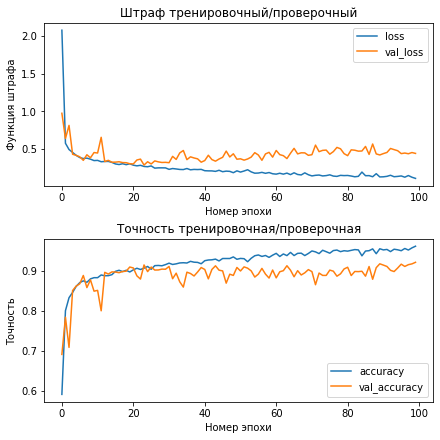

In [111]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

График val_loss постепенно идет вверх, поэтому переобучения есть.

In [112]:
y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels

In [113]:
y_true.shape

(2797,)

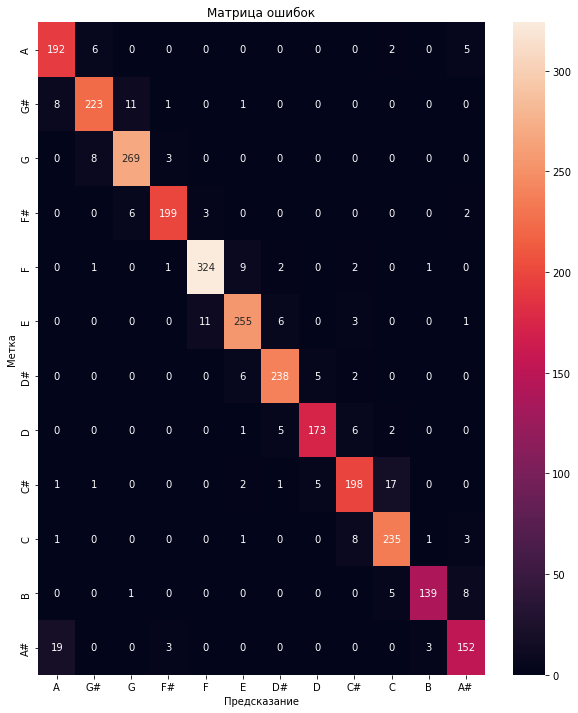

In [114]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [115]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)
files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
output_ds = output_ds.filter(without_zero_len) 
output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
sample_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


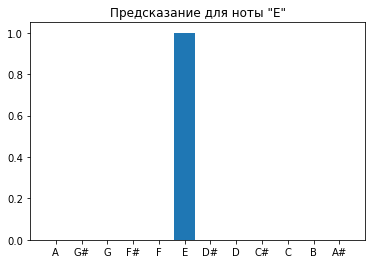

In [116]:
for spectrogram, label in sample_ds.batch(1):
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()


In [122]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_3.h5")

In [118]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    M = tf.convert_to_tensor(params[2])
    NFFT = 2048
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров
    
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
        
    return spectrogram

In [119]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram((waveform,512,25))


print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: D#
Waveform shape: (11506,)
Spectrogram shape: (25, 40)
Audio playback


In [27]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

C:\Users\belas\AppData\Local\Temp/ipykernel_548/3168724974.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


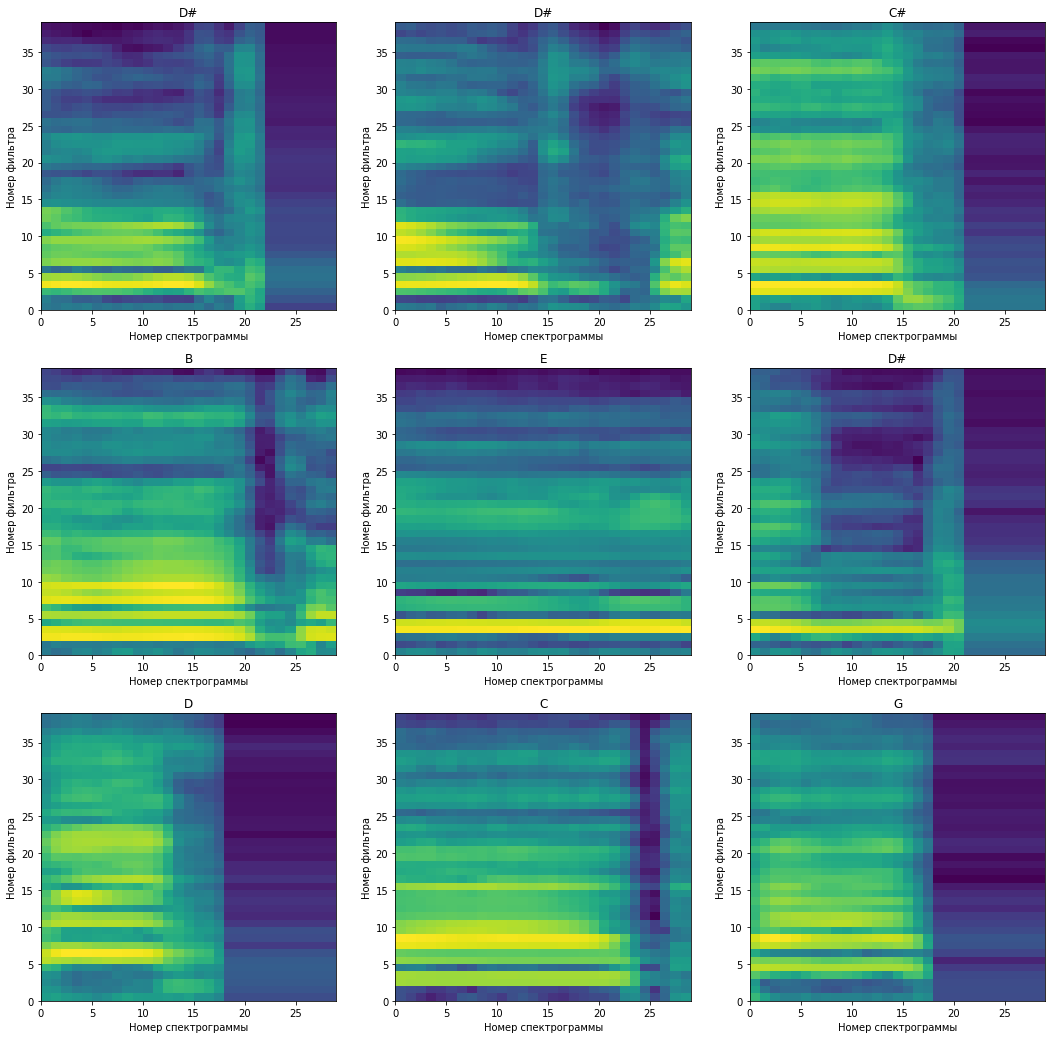

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер фильтра')


plt.show()